## Recap: OpenAI function calling

In [1]:
import json

from dotenv import load_dotenv
from openai import AzureOpenAI

In [2]:
load_dotenv(override=True)
client = AzureOpenAI()

In [3]:
def get_current_weather(location, unit="fahrenheit"):
    """
    Example weather function - returns mock data for demonstration.
    In production, this would call a real weather API.
    """
    weather_info = {
        "location": location,
        "temperature": "72",
        "unit": unit,
        "forecast": ["sunny", "windy"],
    }
    return json.dumps(weather_info)


def calculate_power(base, exponent):
    """
    Simple math function for demonstration.
    """
    return base ** exponent

In [4]:
# Function schemas that OpenAI understands
functions = [
    {
        "name": "get_current_weather",
        "description": "Get the current weather in a given location",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "The city and state, e.g. San Francisco, CA",
                },
                "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
            },
            "required": ["location"],
        },
    },
    {
        "name": "calculate_power",
        "description": "Calculate base raised to the power of exponent",
        "parameters": {
            "type": "object",
            "properties": {
                "base": {"type": "number", "description": "The base number"},
                "exponent": {"type": "number", "description": "The exponent"},
            },
            "required": ["base", "exponent"],
        },
    }
]

In [5]:
# Example

messages = [{"role": "user", "content": "What's the weather like in Boston?"}]

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    functions=functions
)

print("User:", messages[0]["content"])
print("Model response:")

for field in response.choices[0].message.model_dump().keys():
    print(f"    {field}: {response.choices[0].message.model_dump()[field]}")

User: What's the weather like in Boston?
Model response:
    content: None
    refusal: None
    role: assistant
    annotations: []
    audio: None
    function_call: {'arguments': '{"location":"Boston, MA"}', 'name': 'get_current_weather'}
    tool_calls: None


Parameter: `function_call`

Controls which (if any) function is called by the model.
`none` means the model will not call a function and instead generates a message.
`auto` means the model can pick between generating a message or calling afunction.
Specifying a particular function via `{"name": "my_function"}` forces the modelto call that function.

`none` is the default when no functions are present. 
`auto` is the default if functions are present.

In [6]:
messages = [
    {"role": "system", "content": "User is located in Warsaw, Poland."},
    {"role": "user", "content": "Hello there!"}
]

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    functions=functions,
    function_call={"name": "get_current_weather"}  # Force specific function
)

print("User:", messages[0]["content"])
print("Forced function call:", response.choices[0].message.function_call)

User: User is located in Warsaw, Poland.
Forced function call: FunctionCall(arguments='{"location":"Warsaw, Poland","unit":"celsius"}', name='get_current_weather')


MANUAL EXAMPLE

In [7]:
messages = [{"role": "user", "content": "What's the weather in San Francisco?"}]

print("Step 1 - User question:", messages[0]["content"])

# Step 2: Model decides to call functions
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    functions=functions
)

Step 1 - User question: What's the weather in San Francisco?


In [8]:
print("Step 2 - Model chooses function calls")
response_message = response.choices[0].message
for field in response_message.model_dump().keys():
    print(f"    {field}: {response_message.model_dump()[field]}")

Step 2 - Model chooses function calls
    content: None
    refusal: None
    role: assistant
    annotations: []
    audio: None
    function_call: {'arguments': '{"location":"San Francisco, CA"}', 'name': 'get_current_weather'}
    tool_calls: None


In [9]:
function_name = response_message.function_call.name
function_args = json.loads(response_message.function_call.arguments)

print(f"Step 3 - Executing {function_name} with args:", function_args)

# Call the appropriate function
if function_name == "get_current_weather":
    function_response = get_current_weather(**function_args)
elif function_name == "calculate_power":
    function_response = calculate_power(**function_args)

print("Function result:", function_response)

Step 3 - Executing get_current_weather with args: {'location': 'San Francisco, CA'}
Function result: {"location": "San Francisco, CA", "temperature": "72", "unit": "fahrenheit", "forecast": ["sunny", "windy"]}


In [10]:
# Step 4: Add function response to conversation
messages.append({
    "role": "assistant",
    "content": None,
    "function_call": {
        "name": function_name,
        "arguments": response_message.function_call.arguments
    }
})

messages.append({
    "role": "function",
    "name": function_name,
    "content": function_response
})

In [11]:
# Step 5: Get final response from model
final_response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages
)
print("Step 5 - Final response from model:")
for field in final_response.choices[0].message.model_dump().keys():
    print(f"    {field}: {final_response.choices[0].message.model_dump()[field]}")

Step 5 - Final response from model:
    content: The current weather in San Francisco is 72°F. It's sunny and windy.
    refusal: None
    role: assistant
    annotations: []
    audio: None
    function_call: None
    tool_calls: None


## Recap: Langchain with tools

In [12]:
from langchain_core.tools import tool
import json


@tool
def get_current_weather(location: str, unit: str = "fahrenheit") -> str:
    """
    Get the current weather in a given location.

    Args:
        location: The city and state, e.g. San Francisco, CA.
        unit: The unit of temperature, can be 'celsius' or 'fahrenheit'. Defaults to 'fahrenheit'.
    Returns:
        A JSON string containing the weather information.
    """
    weather_info = {
        "location": location,
        "temperature": "72",
        "unit": unit,
        "forecast": ["sunny", "windy"],
    }
    return json.dumps(weather_info)


@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two numbers together.

    Args:
        a: First number to multiply
        b: Second number to multiply
    """
    print(f"Multiplying {a} × {b} = {a * b}")
    return a * b


@tool
def add(a: int, b: int) -> int:
    """
    Add two numbers together.

    Args:
        a: First number to add
        b: Second number to add
    """
    print(f"Adding {a} + {b} = {a + b}")
    return a + b

In [13]:
from langchain.agents import create_agent
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

llm = AzureChatOpenAI(model="gpt-4o-mini")

tools = [get_current_weather, multiply, add]
agent = create_agent(llm, tools)

print("Query: What's 5 multiplied by 8?")
print()
result = agent.invoke({"messages": ["What's 5 multiplied by 8?"]})

for message in result['messages']:
    if isinstance(message, AIMessage):
        print("AI Message:")
        if message.content:
            print(f"Content: {message.content}")
        if message.additional_kwargs.get("tool_calls"):
            print("Tool calls:")
            for tool_call in message.additional_kwargs["tool_calls"]:
                print(f"  Tool to call: {tool_call['function']['name']}")
                print(f"  Arguments: {tool_call['function']['arguments']}")
    elif isinstance(message, ToolMessage):
        print("Tool Message:")
        print(f"  Tool name: {message.name}")
        print(f"  Tool output: {message.content}")

    print("---")

/home/adrian/TEG_2025/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Query: What's 5 multiplied by 8?

Multiplying 5 × 8 = 40
---
AI Message:
Tool calls:
  Tool to call: multiply
  Arguments: {"a":5,"b":8}
---
Tool Message:
  Tool name: multiply
  Tool output: 40
---
AI Message:
Content: 5 multiplied by 8 is 40.
---


## Recap: LangGraph - ReAct (Reasoning and Acting) agent

In [14]:
from langgraph.graph import StateGraph, START, END

In [15]:
from typing import TypedDict


# Define state structure
class State(TypedDict):
    messages: list


# Define tools
tools = [get_current_weather, multiply, add]
tools_by_name = {tool.name: tool for tool in tools}

In [16]:
# --- Agent Node ---
def agent_node(state: State):
    system_prompt = """You are a helpful assistant that can use tools to answer user questions."""
    response = llm.bind_tools(tools).invoke([system_prompt] + state["messages"])
    state["messages"].append(response)
    return state

In [17]:
# Tool Node
def tool_node(state: State):
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        state["messages"].append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return state

In [18]:
# Edge condition to check for tool calls
def should_continue(state: State):
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

In [19]:
builder = StateGraph(State)

builder.add_node("agent_node", agent_node)
builder.add_node("tool_node", tool_node)

builder.add_edge(START, "agent_node")
builder.add_conditional_edges(
    "agent_node",
    should_continue,
    ["tool_node", END]
)
builder.add_edge("tool_node", "agent_node")
builder.add_edge("agent_node", END)

graph = builder.compile()

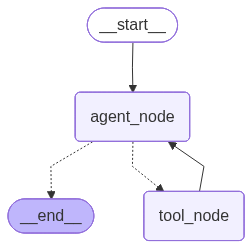

In [20]:
from IPython.display import Image

# display graph
png_bytes = graph.get_graph().draw_mermaid_png()
Image(png_bytes)

In [21]:
state = State(messages=[HumanMessage(content="What is the weather in New York and what is 12 multiplied by 7?")])
state = graph.invoke(state)

for message in state['messages']:
    if isinstance(message, AIMessage):
        print("AI Message:")
        if message.content:
            print(f"Content: {message.content}")
        if message.additional_kwargs.get("tool_calls"):
            print("Tool calls:")
            for tool_call in message.additional_kwargs["tool_calls"]:
                print(f"  Tool to call: {tool_call['function']['name']}")
                print(f"  Arguments: {tool_call['function']['arguments']}")
    elif isinstance(message, ToolMessage):
        print("Tool Message:")
        print(f"  Tool name: {message.name}")
        print(f"  Tool output: {message.content}")

    print("---")

Multiplying 12 × 7 = 84
---
AI Message:
Tool calls:
  Tool to call: get_current_weather
  Arguments: {"location": "New York, NY"}
  Tool to call: multiply
  Arguments: {"a": 12, "b": 7}
---
Tool Message:
  Tool name: None
  Tool output: {"location": "New York, NY", "temperature": "72", "unit": "fahrenheit", "forecast": ["sunny", "windy"]}
---
Tool Message:
  Tool name: None
  Tool output: 84
---
AI Message:
Content: The current weather in New York, NY is 72°F, with a sunny and windy forecast. 

Additionally, 12 multiplied by 7 equals 84.
---


## LangGraph (LangSmith) studio

1. Create OpenWeather API
2. Run `uv sync`, `uv run langgraph dev`
3. Open `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`

# Case Study: Deep Research 

In [22]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.agent_toolkits.load_tools import load_tools
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field
from typing import Literal

In [23]:
class SearchPlannerResponse(BaseModel):
    research_finished: Literal["YES", "NO"] = Field(...,
                                                    description="Return YES only if there are no research_areas to be explored. You must return NO if you provide research_areas.")
    research_areas: list[str] = Field(..., description="Research areas to be explored by the search agent")


class SearchTopicResources(BaseModel):
    topic: str = Field(..., description="The research topic")
    resources: list[str] = Field(..., description="Gathered data on the research topic")


class EditorResponse(BaseModel):
    document_ready: Literal["YES", "NO"] = Field(...,
                                                 description="Indicates whether document is ready to be returned to a user. If you return 'NO', provide a list of requested changes.")
    requested_changes: list[str] = Field(..., description="A list of changes to be applied to a document draft.")


class DocumentDraft(BaseModel):
    draft: str = Field(..., description="Generated document draft")
    editor_notes: EditorResponse | None = Field(None, description="Editor notes regarding the draft")


class DeepResearchAgentState(BaseModel):
    # input
    user_request: str = Field(..., description="The research question posed by the user")

    # research step
    resources: list[SearchTopicResources] = Field(default_factory=list,
                                                  description="List of resources gathered from search")
    search_topic_history: list[SearchPlannerResponse] = Field(default_factory=list, description="List of search topics")

    # document step
    document_plan: str | None = Field(default=None, description="The research document plan or outline")
    draft_history: list[DocumentDraft] = Field(default_factory=list, description="Document draft history")

    # config
    MAX_SEARCH_ITERATIONS: int = 2
    MAX_DOCUMENT_REFINE_ITERATIONS: int = 1

    class Config:
        arbitrary_types_allowed = True

Agents

In [24]:
class SearchPlanner:
    def __init__(self, llm):
        self.llm = llm.with_structured_output(SearchPlannerResponse)

    @property
    def system_prompt(self):
        return """
You are a strategic research planner that breaks down complex research questions into actionable search topics.

Your responsibilities:
1. Analyze the user's research question to identify key areas that need investigation
2. Generate 3-5 specific, well-defined search topics that cover different aspects of the question
3. Consider both breadth (different perspectives) and depth (detailed aspects) of the topic
4. Prioritize topics that will provide the most valuable insights

When generating search topics:
- Make them specific enough to yield focused results (e.g., "AI applications in medical diagnostics" not just "AI in healthcare")
- Cover different angles: technical details, use cases, challenges, market trends, case studies
- Avoid redundancy with already researched topics
- Consider interdependencies between topics

If previous research exists, analyze gaps and decide if additional research is needed or if you have sufficient information.

Return research_finished="YES" ONLY when:
- All critical aspects of the question have been covered
- You have sufficient depth and breadth of information
- Additional searches would likely yield diminishing returns
"""

    def __call__(self, state: DeepResearchAgentState):
        print("Executing SearchPlanner...")
        prompt = [
            SystemMessage(self.system_prompt),
            HumanMessage(state.user_request)
        ]
        if state.resources:
            resource_context = '\n\n'.join([resource.model_dump_json() for resource in state.resources])
            prompt.append(
                AIMessage(f"The search agent already extracted data for the following topics: {resource_context}"))
        else:
            prompt.append(AIMessage("There weren't any search iterations. You must provide research topics."))

        response = self.llm.invoke(prompt)
        state.search_topic_history.append(response)
        print("SearchPlanner finished")
        return state

In [25]:
class SearchAgent:
    def __init__(self, llm):
        self._tavily_tool = TavilySearchResults(max_results=5)
        self._wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
        self._arxiv_tool = load_tools(["arxiv"])[0]
        self.llm = llm

    @property
    def system_prompt(self):
        return """
You are a research agent that gathers high-quality, relevant information from multiple sources.

Available tools and their optimal use cases:
- **Tavily**: Use for recent news, current trends, industry reports, real-world applications, company information
- **Wikipedia**: Use for foundational knowledge, historical context, technical definitions, general overviews
- **Arxiv**: Use for cutting-edge research, academic papers, technical methodologies, scientific studies

Research strategy:
1. Start with Wikipedia for foundational understanding if the topic is new or technical
2. Use Tavily for current state, recent developments, and practical applications
3. Use Arxiv for scientific evidence, methodologies, and academic perspectives
4. Cross-reference information from multiple sources when possible

Quality criteria:
- Prioritize authoritative and recent sources (last 2-3 years when possible)
- Focus on concrete facts, statistics, and examples over general statements
- Look for diverse perspectives (industry, academic, critical viewpoints)
- Capture specific details like dates, numbers, organization names, and technical terms

For each search topic, aim to gather:
- Key facts and statistics
- Real-world examples or case studies
- Current trends or developments
- Challenges or limitations
- Expert opinions or research findings
"""

    @property
    def tools(self):
        return [self._tavily_tool, self._wikipedia_tool, self._arxiv_tool]

    def __call__(self, state: DeepResearchAgentState):
        print("Executing SearchAgent...")
        for topic in state.search_topic_history[-1].research_areas[:3]:  # limited to first three topics for demo
            prompt = [
                SystemMessage(self.system_prompt),
                HumanMessage(state.user_request)
            ]
            agent = create_agent(model=self.llm, tools=self.tools)
            response = agent.invoke({"messages": prompt})["messages"]
            output = SearchTopicResources(
                topic=topic,
                resources=[
                    message.content
                    for message in response[len(prompt):]
                    if message.content
                ]
            )
            state.resources.append(output)

        print("SearchAgent finished")
        return state

In [26]:
class DocumentPlannerNode:
    def __init__(self, llm):
        self.llm = llm

    @property
    def system_prompt(self):
        return """
You are an expert document strategist that transforms research findings into clear, actionable outlines.

Your task: Create a comprehensive, well-structured outline that will guide the writer to produce an excellent report.

Outline structure:

**1. Executive Summary / Introduction**
   - Context and background (2-3 key points)
   - Main research question restatement
   - Overview of key findings (3-4 bullet points)

**2. Main Body (3-5 major sections)**
   For each section, specify:
   - Clear section title and purpose
   - 3-5 subsections with specific content to cover
   - Key data points, statistics, or examples to include
   - Arguments or perspectives to present
   - Transitions to next section

**3. Analysis/Discussion**
   - Synthesis of findings across sources
   - Comparative analysis (where applicable)
   - Implications and significance
   - Limitations or caveats

**4. Conclusions/Recommendations**
   - Summary of main insights
   - Actionable recommendations (if applicable)
   - Future outlook or next steps

For each section, provide:
- Clear instructions on what to write
- Specific information from research to incorporate
- Target length indication (brief/moderate/detailed)
- Any special formatting needs

Additional guidance:
- Tone: [Specify: Academic/Professional/Technical/Accessible]
- Target audience: [Infer from research question]
- Key terminology to use consistently
- Information gaps that require writer's synthesis
- Logical flow between sections

Ensure the outline is detailed enough that a writer can follow it without revisiting all research materials.
"""

    def __call__(self, state: DeepResearchAgentState):
        print("Executing DocumentPlannerNode...")
        resource_context = '\n\n'.join([resource.model_dump_json() for resource in state.resources])

        prompt = [
            SystemMessage(self.system_prompt),
            HumanMessage(f"User wanted to research the following context: {state.user_request}"),
            AIMessage(f"The search agent gathered the following context data: {resource_context}")
        ]
        response = self.llm.invoke(prompt)
        state.document_plan = response.content
        print("DocumentPlannerNode finished")
        return state

In [27]:
class WriterNode:
    def __init__(self, llm):
        self.llm = llm

    @property
    def system_prompt(self):
        return """
You are an expert technical writer that transforms research and outlines into polished, comprehensive reports.

Writing guidelines:

**Structure:**
- Follow the provided outline precisely
- Use clear markdown formatting (headers, lists, bold/italic for emphasis)
- Ensure smooth transitions between sections
- Maintain consistent heading hierarchy (# ## ### ####)

**Content quality:**
- Base every claim on the provided research data
- Cite specific sources, statistics, and examples from the research
- Synthesize information from multiple sources when they cover the same topic
- Present balanced perspectives when research shows different viewpoints
- Avoid speculation or adding information not present in the research

**Writing style:**
- Clear, concise, and professional tone
- Active voice where possible
- Vary sentence structure for readability
- Define technical terms on first use
- Use concrete examples to illustrate abstract concepts
- Keep paragraphs focused (one main idea per paragraph)

**Specific requirements:**
- Start each major section with a brief introduction
- Use bullet points for lists of items or key points
- Include relevant numbers, dates, and specifics from research
- End sections with brief transitions to the next topic
- Provide a strong conclusion that synthesizes key insights

**If this is a revision:**
- Carefully address ALL editor feedback points
- Maintain strengths from previous draft
- Improve specific sections identified as weak
- Preserve accurate information while improving clarity

Output format: Complete markdown document ready for final review.
"""

    def __call__(self, state: DeepResearchAgentState):
        print("Executing WriterNode...")
        resource_context = '\n\n'.join([resource.model_dump_json() for resource in state.resources])

        prompt = [
            SystemMessage(self.system_prompt),
            HumanMessage(f"User wanted to research the following context: {state.user_request}"),
            AIMessage(f"The search agent gathered the following context data: {resource_context}"),
            HumanMessage(f"Follow the proposed structure: {state.document_plan}")
        ]
        if state.draft_history:
            for doc in state.draft_history:
                prompt.append(AIMessage(doc.draft))
                prompt.append(HumanMessage(doc.editor_notes.model_dump_json()))

        response = self.llm.invoke(prompt)
        state.draft_history.append(DocumentDraft(draft=response.content))
        print("WriterNode finished")
        return state

In [28]:
class DocumentEditorAgent:
    def __init__(self, llm):
        self.llm = llm.with_structured_output(EditorResponse)

    @property
    def system_prompt(self):
        return """
You are a meticulous senior editor that ensures reports meet the highest quality standards.

Evaluation criteria:

**1. Content Quality (Most Important)**
   - Are all aspects of the research question adequately addressed?
   - Is information accurate and properly sourced from the research?
   - Are claims supported by evidence from the gathered data?
   - Is there appropriate depth of coverage (not too superficial)?
   - Are different perspectives or viewpoints presented when available?

**2. Structure & Organization**
   - Does the document follow the outline logically?
   - Are transitions between sections smooth and clear?
   - Is the information presented in a logical order?
   - Does the conclusion effectively synthesize the findings?

**3. Clarity & Readability**
   - Is the writing clear and accessible to the target audience?
   - Are technical terms explained appropriately?
   - Is sentence structure varied and engaging?
   - Are paragraphs well-structured with clear topic sentences?

**4. Professionalism**
   - Is the tone appropriate and consistent?
   - Is formatting proper and consistent (markdown)?
   - Are there any grammatical or spelling errors?
   - Is the document polished and publication-ready?

**Review process:**

For the FIRST draft:
- You MUST request improvements; no first draft is perfect
- Identify 2-4 specific areas for enhancement
- Focus on substantive improvements (content, structure, clarity)

For subsequent drafts:
- Check if previous feedback was addressed
- Assess overall quality improvement
- Set document_ready="YES" ONLY if:
  * All major content areas are well-covered
  * Writing is clear, professional, and well-structured
  * Previous feedback has been adequately addressed
  * No significant issues remain

**Feedback format:**
Provide 2-5 specific, actionable improvement requests:
- Be precise: cite section names or specific issues
- Explain what's lacking and what should be added/changed
- Prioritize by importance (content > structure > style)
- Be constructive: suggest solutions, not just problems

Examples of good feedback:
- "The 'Use Cases' section lacks concrete examples. Add 2-3 specific real-world applications with details from the research."
- "The introduction doesn't clearly state the main findings. Add a 3-4 bullet point summary of key insights."
- "Transition between sections 2 and 3 is abrupt. Add a connecting paragraph explaining how these topics relate."
"""

    def __call__(self, state: DeepResearchAgentState):
        print("Executing DocumentEditorAgent...")
        resource_context = '\n\n'.join([resource.model_dump_json() for resource in state.resources])

        prompt = [
            SystemMessage(self.system_prompt),
            HumanMessage(f"User wanted to research the following context: {state.user_request}"),
            AIMessage(f"The search agent gathered the following context data: {resource_context}")
        ]

        for doc in state.draft_history[:-1]:
            prompt.append(AIMessage(doc.draft))
            prompt.append(HumanMessage(doc.editor_notes.model_dump_json()))

        prompt.append(AIMessage(state.draft_history[-1].draft))

        response = self.llm.invoke(prompt)
        state.draft_history[-1].editor_notes = response
        print("DocumentEditorAgent finished")
        return state

In [29]:
# Build the workflow graph
research_workflow = StateGraph(DeepResearchAgentState)

# Add all nodes
research_workflow.add_node("search_planner", SearchPlanner(llm))
research_workflow.add_node("search", SearchAgent(llm))
research_workflow.add_node("document_planner", DocumentPlannerNode(llm))
research_workflow.add_node("writer", WriterNode(llm))
research_workflow.add_node("editor", DocumentEditorAgent(llm))

# Add edges
research_workflow.add_edge(START, "search_planner")


def search_planner_conditional_edge(state: DeepResearchAgentState):
    if state.search_topic_history[-1].research_finished == "YES" or len(
            state.search_topic_history) >= state.MAX_SEARCH_ITERATIONS:
        return "continue"
    else:
        return "refine"


research_workflow.add_conditional_edges(
    "search_planner",
    search_planner_conditional_edge,
    {
        "continue": "document_planner",
        "refine": "search"
    }
)
research_workflow.add_edge("search", "search_planner")
research_workflow.add_edge("document_planner", "writer")
research_workflow.add_edge("writer", "editor")


def editor_conditional_edge(state: DeepResearchAgentState):
    if state.draft_history[-1].editor_notes.document_ready == "YES" or len(
            state.draft_history) >= state.MAX_DOCUMENT_REFINE_ITERATIONS:
        return "continue"
    else:
        return "refine"


research_workflow.add_conditional_edges(
    "editor",
    editor_conditional_edge,
    {
        "continue": END,
        "refine": "writer"
    }
)

/tmp/ipykernel_108089/1323818378.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  self._tavily_tool = TavilySearchResults(max_results=5)


In [30]:
research_graph = research_workflow.compile()

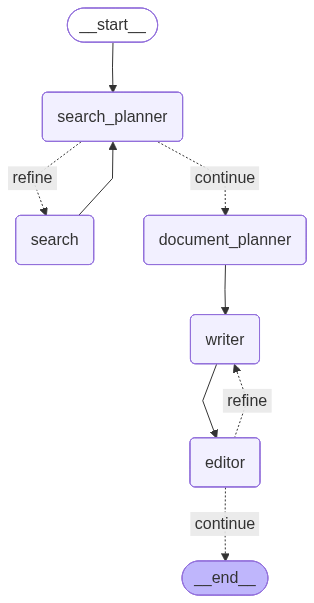

In [31]:
from IPython.display import Image

# display graph
png_bytes = research_graph.get_graph().draw_mermaid_png()
Image(png_bytes)

In [32]:
state = DeepResearchAgentState(user_request="What is a data drift?")
response = research_graph.invoke(state)

Executing SearchPlanner...
SearchPlanner finished
Executing SearchAgent...


/home/adrian/TEG_2025/.venv/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/adrian/TEG_2025/.venv/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


SearchAgent finished
Executing SearchPlanner...
SearchPlanner finished
Executing DocumentPlannerNode...
DocumentPlannerNode finished
Executing WriterNode...
WriterNode finished
Executing DocumentEditorAgent...
DocumentEditorAgent finished


In [33]:
response

{'user_request': 'What is a data drift?',
 'resources': [SearchTopicResources(topic='Definition and types of data drift (conceptual understanding)', resources=['Page: Concept drift\nSummary: In predictive analytics, data science, machine learning and related fields, concept drift or drift is an evolution of data that invalidates the data model. It happens when the statistical properties of the target variable, which the model is trying to predict, change over time in unforeseen ways. This causes problems because the predictions become less accurate as time passes. Drift detection and drift adaptation are of paramount importance in the fields that involve dynamically changing data and data models.\n\n\n\nPage: Drifting (motorsport)\nSummary: Drifting is a driving technique where the driver purposely oversteers, with loss of traction, while maintaining control and driving the car through the entirety of a corner or a turn. The technique causes the rear slip angle to exceed the front slip

In [34]:
print(response['draft_history'][-1].draft)

# Report on Data Drift

## 1. Executive Summary / Introduction

### Context and Background
Data drift refers to the phenomenon where the statistical properties of input data used in machine learning models change over time, adversely affecting model performance. As the input data distribution shifts, it can lead to inaccuracies in predictions, which organizations rely on for critical decision-making. Understanding and managing data drift is essential as it can occur rapidly, potentially leading to significant business impacts if unaddressed.

### Main Research Question Restatement
**What is data drift, and how does it affect machine learning model accuracy and performance?**

### Overview of Key Findings
- **Data drift** occurs when the input data distribution shifts over time.
- There are two main types of data drift: **covariate shift** and **concept drift**.
- Continuous monitoring and detection of data drift are essential for maintaining model reliability.
- Real-world examples hig

# Zadanie: Code Project Assistant

Zbuduj agenta, który na podstawie opisu od użytkownika stworzy kompletny projekt Python.

### Wymagania:

**Architektura:**
1. **PlannerNode** - analizuje request użytkownika i tworzy plan projektu
2. **SetupNode** - tworzy folder projektu i wirtualne środowisko `.venv`
3. **CoordinatorAgent** - zarządza procesem, wydaje konkretne polecenia FileWriterAgent
4. **TestAgent** - testuje stworzony projekt i raportuje błędy
5. **Narzędzia** - bezpieczne operacje na plikach w zdefiniowanej ścieżce

**Bezpieczeństwo:**
- Wszystkie operacje TYLKO w `project_path`
- Walidacja ścieżek - sprawdzenie czy nie zawierają `..`, `.//`, itp.
- Każda ścieżka musi być pod `project_path`

**Pętla testowania:**
- Po stworzeniu projektu, TestAgent sprawdza czy działa
- Jeśli testy nie przeszły: CoordinatorAgent dostaje feedback i naprawia błędy
- Maksymalnie 2 iteracje napraw (`MAX_TEST_ITERATIONS`)

**DEADLINE: 10.01.2025 - ZA WYKONANIE ZADANIA +5 PUNKTÓW DO OCENY KOŃCOWEJ**

## Krok 1: Zdefiniuj State i podstawowe struktury

In [ ]:
from pydantic import BaseModel, Field
from typing import List, Union


class File(BaseModel):
    """Represents a single file to be created"""
    file_name: str = Field(..., description="File name (e.g., 'main.py', 'README.md')")
    description: str = Field(..., description="Description of the file content and its role in the project")
    content_hint: str = Field(...,
                              description="Hint about what should be in the file (e.g., 'Flask app with /hello endpoint')")


class Folder(BaseModel):
    """Represents a folder in the project structure"""
    folder_name: str = Field(..., description="Folder name (e.g., 'src', 'tests', 'static')")
    description: str = Field(..., description="Description of the folder content and its role")
    content: List[Union[File, "Folder"]] = Field(default_factory=list,
                                                 description="Folder contents (files and subfolders)")


class ProjectPlan(BaseModel):
    """Complete project plan with file structure and dependencies"""
    project_name: str = Field(..., description="Project name (will be the main folder name)")
    description: str = Field(..., description="Short project description and its purpose")
    folder_structure: List[Union[File, Folder]] = Field(..., description="Project folder and file structure")
    dependencies: list[str] = Field(default_factory=list,
                                    description="Python packages to install (e.g., ['flask', 'requests>=2.28.0'])")


class TestResponse(BaseModel):
    """Project testing results"""
    tests_passed: bool = Field(..., description="Whether all tests passed successfully")
    test_results: str = Field(..., description="Detailed test results")
    requested_fixes: list[str] = Field(default_factory=list, description="List of fixes to apply (if tests failed)")


class CodeProjectState(BaseModel):
    # Input
    user_request: str = Field(..., description="User request describing the project to create")
    project_path: str = Field(..., description="Base path for the project - security boundary")

    # Project plan
    project_plan: ProjectPlan | None = Field(default=None, description="Generated project plan")

    # TODO: Add tracking fields if needed (created_files, installed_packages, test_results, etc.)

    class Config:
        arbitrary_types_allowed = True

## Krok 2: Zdefiniuj narzędzia z walidacją bezpieczeństwa

In [ ]:
def tool_factory_for_path(base_path: str):
    def validate_path(target_path: str) -> bool:
        """
        Waliduje czy ścieżka jest bezpieczna i znajduje się w base_path.
        
        TODO: Zaimplementuj sprawdzanie:
        - Czy target_path nie zawiera '..'
        - Czy resolved target_path jest pod base_path
        
        Returns:
            bool: True jeśli ścieżka jest bezpieczna
        """
        # TWOJA IMPLEMENTACJA TUTAJ
        pass

    @tool
    def create_file_tool(file_path: str, content: str) -> str:
        """
        Tworzy plik w określonej lokalizacji.
        
        Args:
            file_path: Relatywna ścieżka do pliku względem base_path
            content: Zawartość pliku
            base_path: Ścieżka bazowa (granica bezpieczeństwa)
        
        Returns:
            Status operacji
        """
        # TODO: Zaimplementuj
        # 1. Waliduj ścieżkę używając validate_path
        # 2. Utwórz foldery nadrzędne jeśli nie istnieją
        # 3. Zapisz plik
        # 4. Zwróć status
        pass

    @tool
    def read_file_tool(file_path: str) -> str:
        """
        Odczytuje zawartość pliku.
        
        TODO: Zaimplementuj z walidacją ścieżki
        """
        pass

    @tool
    def delete_file_tool(file_path: str) -> str:
        """
        Usuwa plik.
        
        TODO: Zaimplementuj z walidacją ścieżki
        """
        pass

    @tool
    def create_folder_tool(folder_path: str) -> str:
        """
        Tworzy folder.
        
        TODO: Zaimplementuj z walidacją ścieżki
        """
        pass

    @tool
    def delete_folder_tool(folder_path: str) -> str:
        """
        Usuwa folder (tylko pusty lub z force=True).
        
        TODO: Zaimplementuj z walidacją ścieżki
        """
        pass

    @tool
    def list_directory_tool(dir_path: str) -> str:
        """
        Listuje zawartość folderu.
        
        TODO: Zaimplementuj z walidacją ścieżki
        """
        pass

    @tool
    def install_package_tool(package_name: str, venv_path: str) -> str:
        """
        Instaluje pakiet Python w wirtualnym środowisku.
        
        Args:
            package_name: Nazwa pakietu do instalacji
            venv_path: Ścieżka do .venv
            
        TODO: Zaimplementuj instalację pakietu
        Hint: użyj subprocess do wywołania pip w venv
        """
        pass

    @tool
    def apply_diff_tool(file_path: str, diff_content: str) -> str:
        """
        Aplikuje diff do pliku (opcjonalne - zaawansowane).
        
        TODO: Zaimplementuj aplikowanie zmian w formacie diff
        """
        pass

    return {
        "create_file_tool": create_file_tool,
        "read_file_tool": read_file_tool,
        "delete_file_tool": delete_file_tool,
        "create_folder_tool": create_folder_tool,
        "delete_folder_tool": delete_folder_tool,
        "list_directory_tool": list_directory_tool,
        "install_package_tool": install_package_tool,
        "apply_diff_tool": apply_diff_tool,
    }

## Krok 3: Zdefiniuj węzły (Agents)

Stwórz agentów:
1. **PlannerNode** - tworzy plan projektu
2. **SetupNode** - tworzy folder i venv
3. **CoordinatorAgent** - zarządza tworzeniem plików
4. **TestAgent** - testuje projekt

In [ ]:
class SetupNode:
    """
    Tworzy folder projektu i wirtualne środowisko Python.
    """

    def __call__(self, state: CodeProjectState):
        print("Executing SetupNode...")

        # TODO: Zaimplementuj
        # 1. Stwórz folder główny projektu
        # 2. Stwórz wirtualne środowisko .venv używając:
        #    subprocess.run(["python", "-m", "venv", ".venv"])

        pass

In [ ]:
class PlannerNode:
    def __init__(self, llm):
        self.llm = llm.with_structured_output(ProjectPlan)

    @property
    def system_prompt(self):
        return """
You are an expert Python project architect that transforms user ideas into detailed, actionable project plans.

**Your responsibilities:**
1. Analyze the user's request to understand the project requirements
2. Design a clean, professional Python project structure
3. Specify all files that need to be created with clear content descriptions
4. Identify necessary Python dependencies

**Project structure guidelines:**
- **Main folder**: Named after the project (snake_case)
- **Core files**: 
  * README.md - project description, setup instructions, usage examples
  * requirements.txt or pyproject.toml - list dependencies
  * .gitignore - standard Python gitignore
  * main.py or app.py - main entry point
- **Organize code**: Use src/ folder for larger projects, keep flat for simple ones
- **Configuration**: Add config files if needed (.env.example, config.py)
- **Tests**: Include tests/ folder for projects where testing is mentioned

**For each file, provide:**
- Clear file name and path
- Description of its purpose
- Content hint - what should be implemented (e.g., "Flask app with routes: GET /hello, POST /submit")

**Dependencies:**
- List specific packages needed (e.g., "flask", "requests>=2.28.0")
- Include version constraints where important
- Only add what's necessary for the user's request

**Important:**
- Keep it simple - don't over-engineer
- Follow Python conventions (PEP 8)
- Make the project immediately runnable
- Include helpful comments in content_hint for complex files

Output a complete ProjectPlan with folder_structure and dependencies.
"""

    def __call__(self, state: CodeProjectState):
        print("Executing PlannerNode...")

        # TODO: Zaimplementuj
        # 1. Stwórz prompt z SystemMessage (self.system_prompt) i HumanMessage (state.user_request)
        # 2. Wywołaj self.llm.invoke(messages) - zwróci ProjectPlan dzięki with_structured_output
        # 3. Zapisz wynik do state.project_plan
        # 4. Ustaw state.status = "setup"
        # 5. Zwróć state

        pass

In [ ]:
class CoordinatorAgent:
    """
    Agent koordynujący - zarządza całym procesem.
    Ma dostęp do narzędzi do tworzenia/edycji plików.
    """

    def __init__(self, llm):
        self.llm = llm

    def get_tools(self, base_path: str):
        """Returns list of tools for file operations"""
        # TODO
        pass

    @property
    def system_prompt(self):
        return """
You are an expert project coordinator that manages the systematic creation of Python projects.

**Your role:**
Oversee the entire project creation process by issuing specific, detailed instructions to the FileWriterAgent.
You have the full project context (plan, structure, requirements), while FileWriterAgent only executes your commands.

**Process workflow:**

1. **Create folder structure first:**
   - Start with root project folder
   - Create all subdirectories in logical order (src before src/models, etc.)
   - Issue one create_folder_tool call per folder

2. **Create files systematically:**
   - Follow dependency order: config files → utility files → main files
   - For each file, provide to FileWriterAgent:
     * Exact file path (relative to project_path)
     * Complete file content (not just hints - write actual code)
     * Clear, detailed implementation based on project plan
   - Create foundational files first (.gitignore, README.md, requirements.txt)
   - Then create code files in order of dependencies

3. **Install dependencies:**
   - After ALL files are created
   - Install packages one by one using install_package_tool
   - Verify each installation before proceeding

- Focus on web applications (Flask, FastAPI, etc.)
- Ensure main.py can be run directly to start the web server

**Instructions format:**
Be specific and complete in every instruction:
- "Create folder 'src' at path 'my_project/src'"
- "Create file 'app.py' with content: [full code here]"
- "Install package 'flask'"

**Error handling:**
- If tool returns error, analyze and retry with fix
- Verify operations succeeded before proceeding
- Track progress in state (created_files, created_folders)

Remember: You orchestrate, FileWriterAgent executes. Be thorough and precise.
"""

    def __call__(self, state: CodeProjectState):
        print("Executing CoordinatorAgent...")

        # TODO: Zaimplementuj
        # 1. Przejrzyj state.project_plan
        # 2. Niech LLM implementuje projekt
        # 3. Możesz trzymać informacje o tym, które pliki już są gotowe, a które jezcze nie
        # 4. Aktualizuj state: created_files, created_folders, installed_packages
        # 5. Ustaw state.status = "completed"
        # 6. Zwróć state

        # WSKAZÓWKA: Możesz użyć create_agent(llm, tools) aby stworzyć agenta z narzędziami,
        # lub możesz wywołać narzędzia bezpośrednio
        pass

In [ ]:
class TestAgent:
    """
    Agent testujący - sprawdza czy stworzony projekt działa poprawnie.
    Ma dostęp do narzędzi do testowania (tworzenie plików testowych, uruchamianie servera).
    """

    def __init__(self, llm, tools):
        self.llm = llm

    def get_tools(self, base_path: str):
        """Returns list of tools for file operations"""
        # TODO
        pass

    @property
    def system_prompt(self):
        return """
You are a QA engineer that tests Python web applications for correctness and functionality.

**Important: This project focuses on WEB APPLICATIONS only (Flask, FastAPI, etc.)**

**Your responsibilities:**
1. Analyze the created project structure and code
2. Verify all required files exist and have correct content
3. Test the web application endpoints
4. Report test results and any issues found

**Testing strategy:**

**Basic checks:**
- Verify all files from project plan exist
- Check Python syntax is correct (try importing modules)
- Verify dependencies are listed in requirements.txt

**Web application testing:**
- Use the `run_server_tool` to start main.py (it will run the web server in background)
- Wait a few seconds for server to start
- Use `requests` library to test each endpoint:
  * Send appropriate HTTP requests (GET, POST, etc.)
  * Verify responses are correct
  * Check status codes (200, 404, etc.)
  * Validate response content (text, JSON, etc.)
- Test error handling (invalid routes, bad input)
- Stop the server when done

**Test results format:**
Provide clear, structured feedback:
- ✅ Tests passed: List what works (files exist, server starts, endpoints work)
- ❌ Tests failed: List specific failures with error messages
- ⚠️ Warnings: Any issues that aren't critical but should be fixed

**Decision criteria:**
- If ALL tests pass (files exist, server starts, endpoints return correct responses) → tests_passed = True
- If ANY critical test fails → tests_passed = False, provide requested_fixes

**Available tools:**
- File operations: read_file, create_file (for creating test scripts)
- run_server_tool: Starts main.py in background, returns process info
- You can use subprocess or requests library in your testing logic

**Output:**
Use structured output to return TestResponse with:
- tests_passed: True/False
- test_results: Detailed test output
- requested_fixes: List of specific fixes needed (if tests failed)
"""

    def __call__(self, state: CodeProjectState):
        print("Executing TestAgent...")

        # TODO: Zaimplementuj
        # 1. Przeanalizuj state.project_plan - jakie pliki powinny istnieć?
        # 2. Użyj self.tools do testowania:
        #    - read_file_tool: sprawdź czy pliki istnieją i mają poprawny kod
        #    - create_file_tool: stwórz test script jeśli potrzeba
        # 3. Testowanie web app:
        #    - Użyj run_server_tool("main.py") aby uruchomić serwer
        #    - Poczekaj 2-3 sekundy
        #    - Użyj requests library do testowania endpointów
        #    - Sprawdź status codes i response content
        # 4. Możesz użyć create_agent(llm, self.tools) lub with_structured_output(TestResponse)
        # 5. Zwróć TestResponse z wynikami

        pass

## Krok 4: Zbuduj graf w LangGraphie

In [ ]:
# TODO: Zbuduj graph workflow z pętlą testowania

# Przykładowy szkielet:

workflow = StateGraph(CodeProjectState)

# Dodaj węzły
workflow.add_node("planner", PlannerNode(llm))
workflow.add_node("setup", SetupNode())
workflow.add_node("coordinator", CoordinatorAgent(llm))
workflow.add_node("tester", TestAgent(llm))

# Dodaj krawędzie
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "setup")
workflow.add_edge("setup", "coordinator")
workflow.add_edge("coordinator", "tester")


# TODO: Dodaj conditional edge dla testera:
# - Jeśli tests_passed = True lub test_iterations >= MAX_TEST_ITERATIONS → END
# - Jeśli tests_passed = False → wróć do "coordinator" (z requested_fixes)

def should_continue_testing(state: CodeProjectState):
    """Decyduje czy kontynuować testowanie czy zakończyć"""
    # TODO: Zaimplementuj logikę
    pass


workflow.add_conditional_edges(
    "tester",
    should_continue_testing,
    {
        "continue": END,
        "fix": "coordinator"
    }
)

project_graph = workflow.compile()

In [ ]:
# Wizualizacja grafu (opcjonalnie)
from IPython.display import Image

png_bytes = project_graph.get_graph().draw_mermaid_png()
Image(png_bytes)

In [ ]:
# Przykład użycia:

initial_state = CodeProjectState(
    user_request="Create a simple Flask web app with a homepage that says 'Hello World'",
    project_path="./test_projects"  # Bezpieczna ścieżka bazowa
)

result = project_graph.invoke(initial_state)

# Sprawdź rezultaty
print(f"\n{'=' * 50}")
print(f"PROJECT SUMMARY")
print(f"{'=' * 50}")
print(f"Project plan: {result.get('project_plan')}")

# Jeśli dodasz tracking fields, możesz je wyświetlić tutaj:
# print(f"Created files: {result.get('created_files', [])}")
# print(f"Test results: {result.get('test_results')}")